<font face='Calibri' size='2'> <i>eSBAE - Notebook Series - Part 5b, version 0.1, April 2023. Andreas Vollrath, UN-Food and Agricultural Organization, Rome</i>
</font>

![title](images/header.png)

# V-b - Supervised Subsampling (global data)
### Run a supervised classification based on Global data for training, and subsample by KMeans-Neyman stratification
-------


In [1]:
import geopandas as gpd
from pathlib import Path
import pandas as pd
import numpy as np
from sampling_handler.misc import py_helpers
from sampling_handler.ensemble import classification as clf
from sampling_handler.ensemble import helpers as h
from matplotlib import pyplot as plt

/home/sepal-user/venv/pre_esbae/lib/python3.8/site-packages/bfast/__init__.py:10: UserWarning: cupy is not available in this environment, GPU fonctionnalities won't be available
  warn("cupy is not available in this environment, GPU fonctionnalities won't be available")


In [ ]:
from sampling_handler import EnsembleClassification

In [ ]:
esbae = EnsembleClassification(

    # your project name (NEEDS to be consistent with previous notebooks of your project)
    project_name = 'my_first_esbae_project',   
    
    
)

In [ ]:
start, end = 2015, 2020

In [ ]:
esbae.get_global_training(start, end, tmf=True, gain=True)

In [ ]:
esbae.class_probability(target='CNC', predictors=['change', 'reflectance'], outlier_removal=True, bayes_optimization=True)

In [ ]:
esbae.plot_probabilites(target='CNC')

In [ ]:
esbae.class_probability(target='FNF', predictors=['bands'], year=start, outlier_removal=True, bayes_optimization=True)
esbae.class_probability(target='FNF', predictors=['bands'], year=end, outlier_removal=True, bayes_optimization=True)

In [ ]:
esbae.probability_df['FNF_max'] = esbae.probability_df[[f'FNF_{start}', f'FNF_{end}']].max(axis=1)

In [ ]:
esbae.probability_df['combined'] = esbae.probability_df['FNF_max'] * esbae.probability_df['CNC'] 

In [ ]:
esbae.kmeans_neymann(strata=3, samples=5000)

In [ ]:
esbae.subsample(sampling_type='space_filling_curve')

#### the enxt cell needs to be replaced, i.e withoyur file and cols to classify might differ

In [2]:
# this is loading and merging my change and time-series dataframe
files = Path('/home/sepal-user/module_results/esbae/Belize_MRV/04_Data_Augmentation/Landsat/').glob('*geojson')
#files = Path('/home/sepal-user/module_results/esbae/Oromia_MRV/04_Data_Augmentation/Landsat/').glob('*geojson')
files = [[str(file), False] for file in files]
result = py_helpers.run_in_parallel(
    py_helpers.geojson_to_gdf,
    files,
    workers=4,
    parallelization='processes'
)
cdf = pd.concat(result)

# define a start and end year
start_year = '2015'
end_year = '2021'



### Add "Ground Truth" from global products

In [3]:
# adds FNF and CNC column for later classifications
# takes Hansen by default for change between the start and end year
cdf = clf.add_global_target(
    cdf, start_year, end_year, 
    tmf=True,      # if True, and TMF shows a change
    gain=True      # if True, Hansen gain will be considered a change
)

### 4 add yearly fnf classification probability

In [5]:
def get_stats(row, band, start, end):
    
    idx = [start*10000 < int(d) < end*10000 for d in row.dates]
    ts = np.array(row.ts[band])[idx]
    
    return np.nanmean(ts), np.nanstd(ts)

bands = cdf.ts.head(1).values[0].keys()
for year in range(int(start_year), int(end_year)+1):
    print(year)
    if year == int(start_year) or year == int(end_year):
    #if year == int(end_year):
        to_class = cdf[[
            'point_id', 'elevation', 'slope', 'aspect', 'FNF'
        ]].copy()
        # prepare full dataframe for classification
        print('Calculating annual FNF classification probabilities')
        stats_list = []
        for band in bands:
            print(band)
            to_class[[f'{band}_{year}_mean', f'{band}_{year}_sd']] = cdf.apply(lambda row: get_stats(row, band, year, year+1), axis=1, result_type='expand')
            

        cdf[f'fnf_prob_{year}'] = clf.binary_probability_classification(to_class, 'FNF', outlier=True, bayes=True)    

2015
Calculating annual FNF classification probabilities
green
red
nir
swir1
swir2
ndfi
2016
2017
2018
2019
2020
2021
Calculating annual FNF classification probabilities
green
red
nir
swir1
swir2
ndfi


### Aggregate to maximum forest prob

In [6]:
cdf['fnf_max_prob'] = cdf[[
    f'fnf_prob_{start_year}', f'fnf_prob_{end_year}'
]].max(axis=1)

In [7]:
cdf['geometry'] = cdf.geometry.centroid

array([<Axes: title={'center': 'fnf_max_prob'}>], dtype=object)

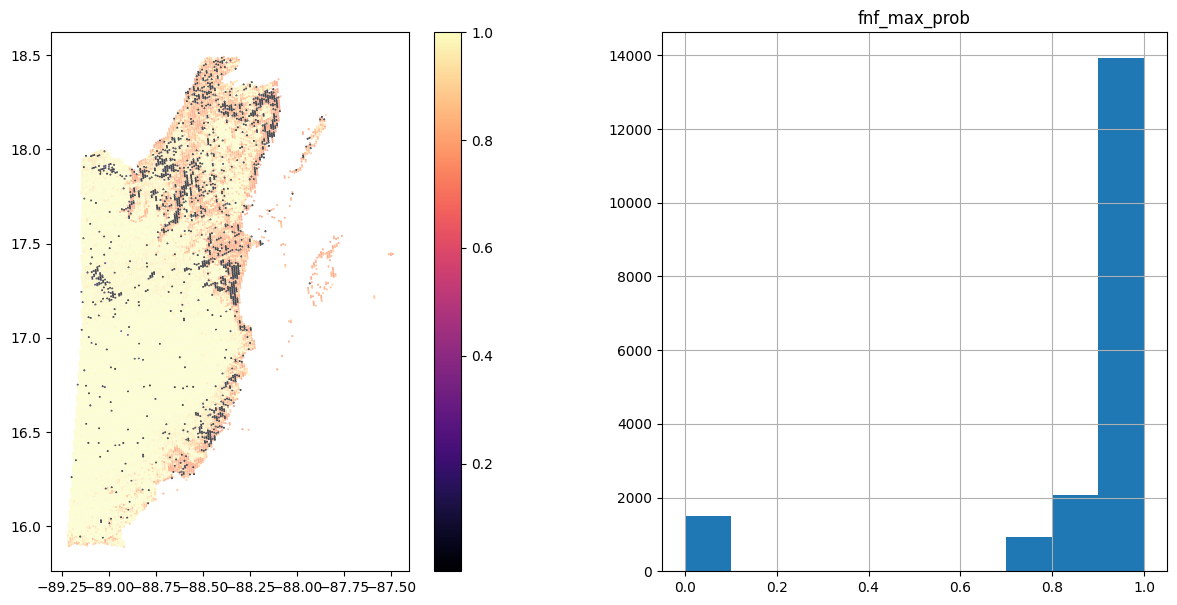

In [8]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

cdf.plot('fnf_max_prob', markersize=0.15, ax=ax[0], legend=True, cmap='magma')
cdf.hist('fnf_max_prob', ax=ax[1])

### Run change/no-change classification

In [9]:
# predictors used change/nochange classification
cols_to_classify = [
    'gfc_tc00', 'mon_images',
    'bfast_magnitude', 'bfast_means',
    'cusum_confidence', 'cusum_magnitude', 
    'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max', 
    'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max',
    'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
    'nir_mean', 'nir_sd', 'nir_min', 'nir_max',
    'red_mean', 'red_sd', 'red_min', 'red_max',
    'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max', 
    'bs_slope_mean', 'bs_slope_sd',
    'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
    'ewma_jrc_magnitude', 'mosum_jrc_change',
    'mosum_jrc_magnitude','cusum_jrc_change',
    'cusum_jrc_magnitude', 'ccdc_magnitude', 'aspect',
    'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
    'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation',
    #'fnf_max_prob'
]

cdf['chg_prob'] = clf.binary_probability_classification(cdf, 'CNC', cols_to_classify, outlier=True)

array([<Axes: title={'center': 'chg_prob'}>], dtype=object)

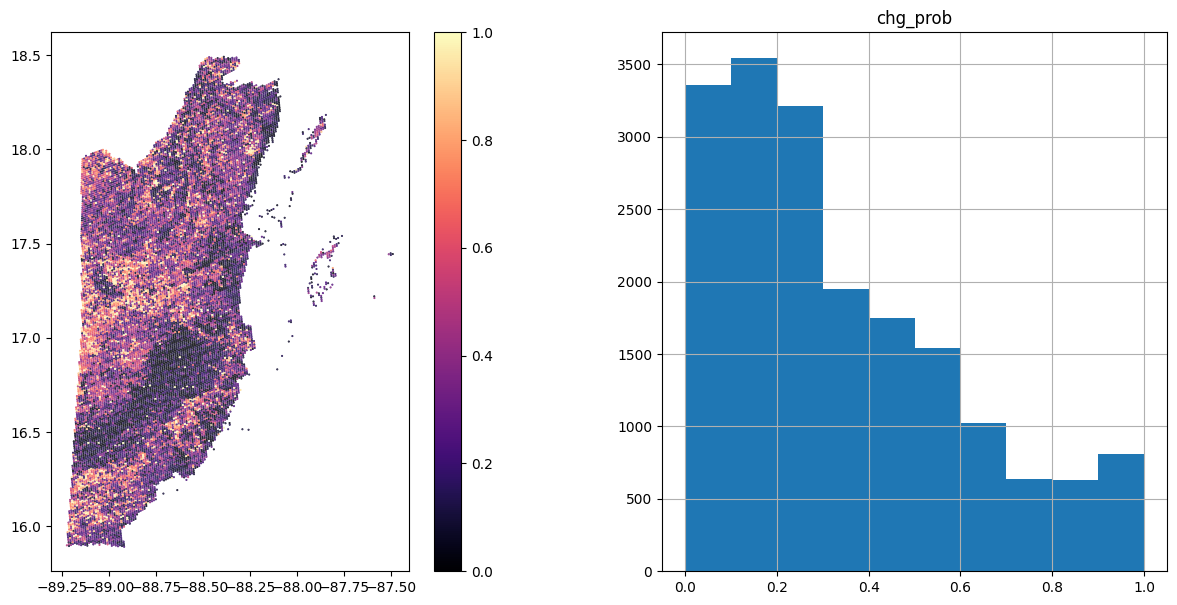

In [10]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

cdf.plot('chg_prob', markersize=0.25, ax=ax[0], legend=True, cmap='magma')
cdf.hist('chg_prob', ax=ax[1])

### Combine probs from Change and Forest

In [12]:
def update(i, j):
    return np.sqrt(i*j)


In [13]:
for i in range(1, 10):
    print(i/10, update(i/10, 0.75), i/10*0.75)

0.1 0.2738612787525831 0.07500000000000001
0.2 0.3872983346207417 0.15000000000000002
0.3 0.4743416490252569 0.22499999999999998
0.4 0.5477225575051662 0.30000000000000004
0.5 0.6123724356957945 0.375
0.6 0.6708203932499369 0.44999999999999996
0.7 0.7245688373094719 0.5249999999999999
0.8 0.7745966692414834 0.6000000000000001
0.9 0.8215838362577492 0.675


In [14]:
cdf['simple_combined'] = cdf.apply(lambda row: update(row.fnf_max_prob, row.chg_prob), axis=1)
cdf['multiplied'] = cdf.fnf_max_prob * cdf.chg_prob

### Stratify with Kmeans instead of Kozak and Neymann allocation

,KMeans,Nh,mean,SD,div,Strata,neyman,proportional
1,1,9132,0.280865,0.148086,1352.321875,1,3319,2475
2,0,6091,0.613599,0.074169,451.762416,2,1108,1650
0,2,3225,0.857812,0.072220,232.910413,3,571,874


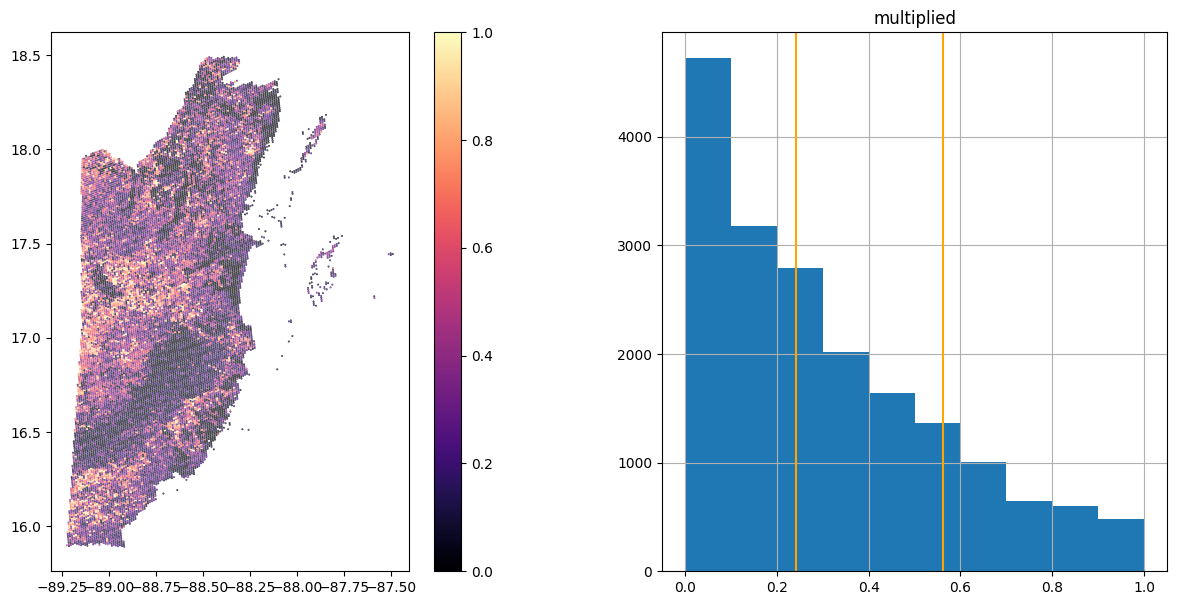

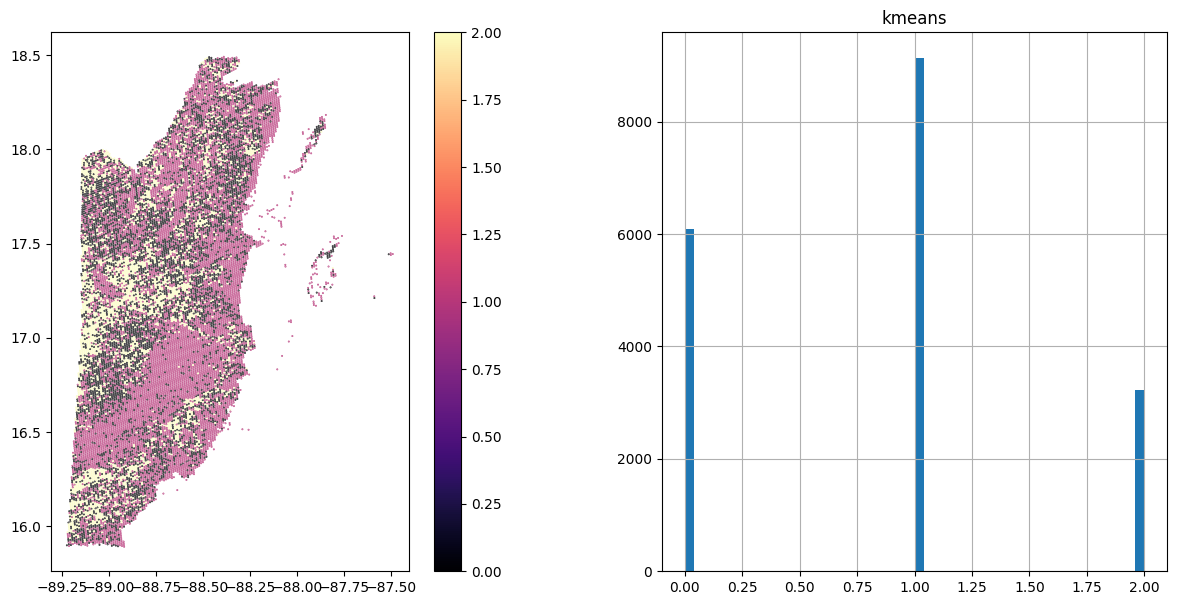

In [17]:
cdf, sample_df = h.kmeans_stratifier(cdf, 'multiplied', strata=3, sample_size=5000)
h.plot_cluster(cdf, prob_column='multiplied', strata_column='kmeans')

fig, ax = plt.subplots(1,2, figsize=(15,7))

cdf.plot('kmeans', markersize=0.15, ax=ax[0], legend=True, cmap='magma')
cdf.hist('kmeans', ax=ax[1], bins=50)
sample_df

,KMeans,Nh,mean,SD,div,Strata,neyman,proportional
2,0,5156,0.175485,0.108572,559.796291,1,1578,1397
1,1,7810,0.489997,0.085893,670.823913,2,1891,2116
0,2,5482,0.791143,0.099038,542.924453,3,1530,1485


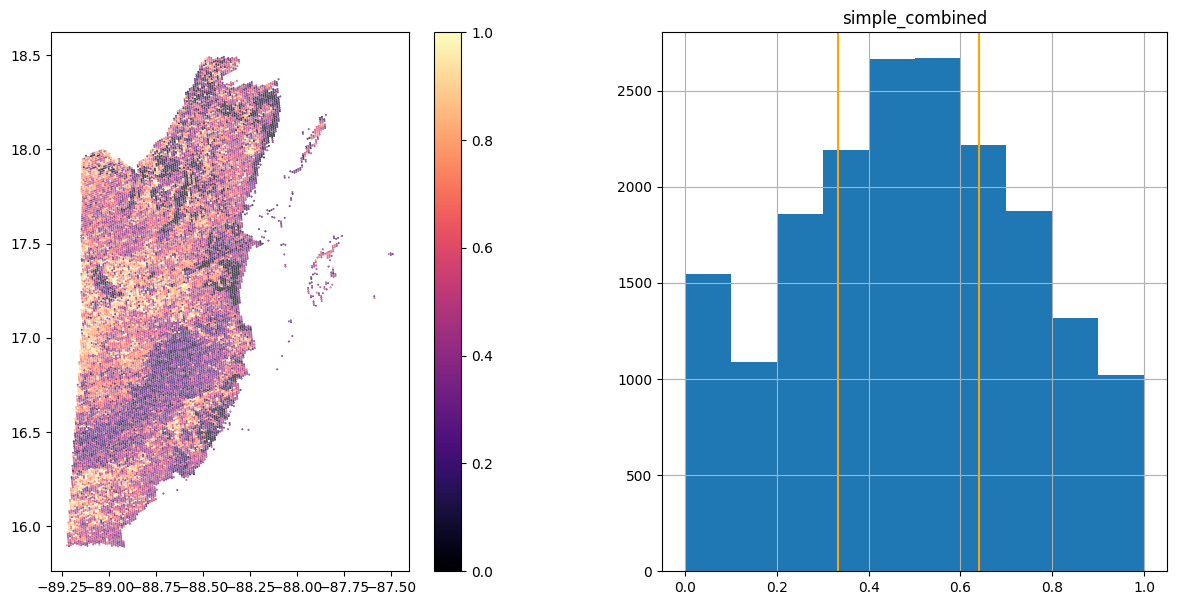

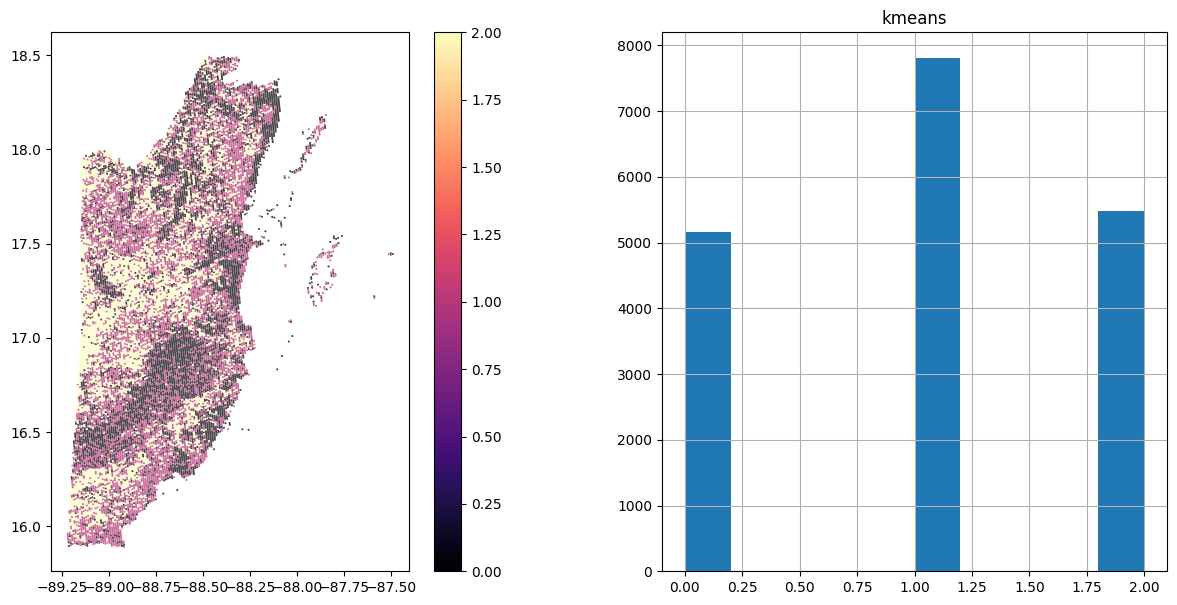

In [16]:
cdf, sample_df = h.kmeans_stratifier(cdf, 'simple_combined', strata=3, sample_size=5000)
h.plot_cluster(cdf, prob_column='simple_combined', strata_column='kmeans')

fig, ax = plt.subplots(1,2, figsize=(15,7))

cdf.plot('kmeans', markersize=0.15, ax=ax[0], legend=True, cmap='magma')
cdf.hist('kmeans', ax=ax[1])
sample_df

In [18]:
from sampling_handler.sampling import sfc

def select_with_space_filling_curve(cdf, sample_df, strata_column='kmeans'):
    dfs = []
    for stratum in cdf[strata_column].unique():
        dfs.append(sfc.sfc_subsample(
            gdf = cdf[cdf[strata_column] == stratum],
            target_point_size = sample_df.neyman[sample_df.KMeans == stratum].values[0]
        ))
        
    return pd.concat(dfs)

samples = select_with_space_filling_curve(cdf, sample_df) 

<Axes: >

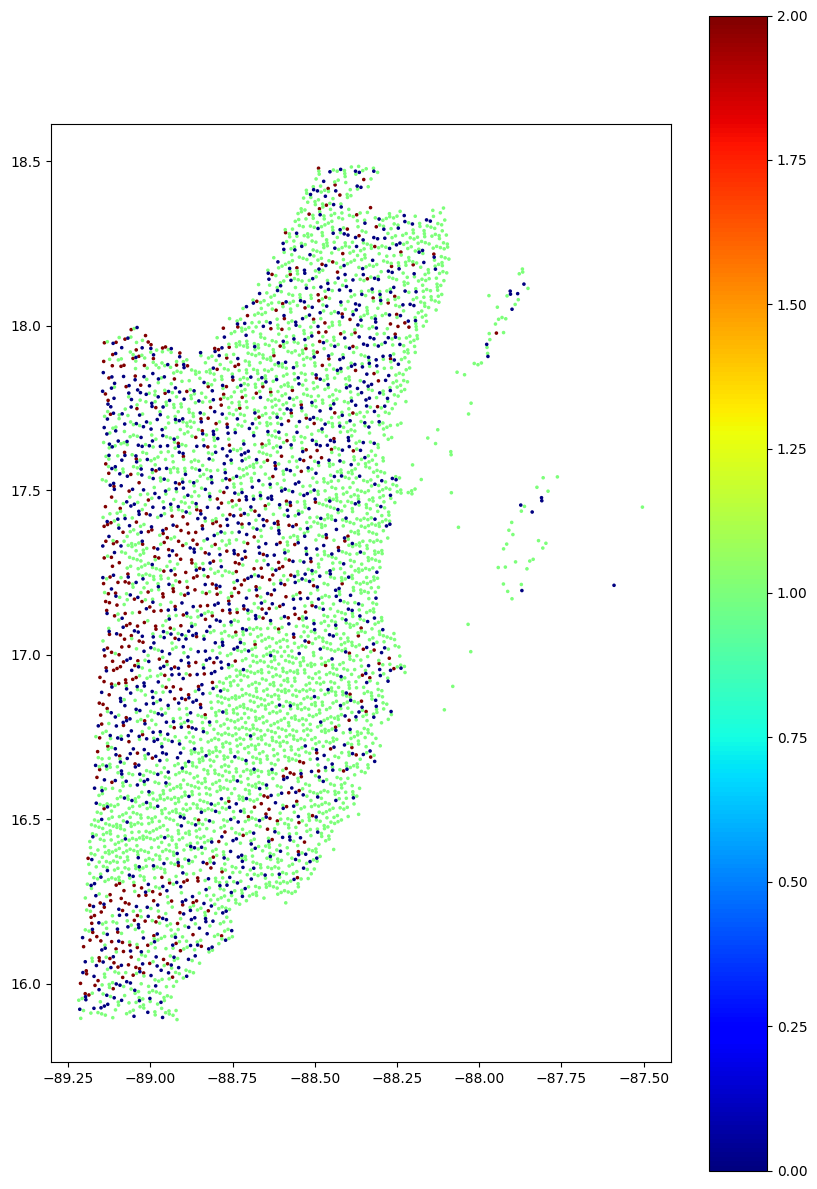

In [19]:
samples.plot('kmeans', markersize=2.5, cmap='jet', legend=True, figsize=(10,15))